# Contributors
Zijian Zhang 14851598 $\\$
Amish Sewlal 13297503 $\\$
Ravi Sharma Kaushik 14332744

# Creating Mandlebrot Set

# Area of Mandlebrot Set using Monte Carlo Method

# Convergence studies for various number of iterations and samples

# Using varous sampling techniques  

# Approach for improving convergence

In [377]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from matplotlib.ticker import ScalarFormatter
from Mandelbrot_h import whenLeaveMandelbrotSet as wlms, orthogonalSampling_h as OS_h
from Mandelbrot import inMandelbrotSet as ims
from MonteCarloIntegration import orthogonalSampling as OS

In [185]:
def RS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by pure random sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    history = np.zeros((s_num, iter_num))
    # history is the historical data for all samples at each step in the iteration
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        theta = U1 * 2 * math.pi
        r = R * math.sqrt(U2)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        j = wlms(c, iter_num)
        # j is the iteration number when c leave the Mandelbrot set
        # If c never leave the Mandelbrot set, j = iter_num
        history[s, :j] = 1

    # Compute the area of the Mandelbrot set
    N_h = history.sum(axis=0)
    # N_h is the number of samples that are in the Mandelbrot set during the run
    A_total = math.pi * R**2  # The area of the sampling region
    A_h = N_h / s_num * A_total

    return A_h


def LHS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by Latin hypercube sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    idx = np.arange(s_num)
    np.random.shuffle(idx)
    history = np.zeros((s_num, iter_num))
    # history is the historical data for all samples at each step in the iteration
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        # Split the circular sampling region into s sectors, and get the RV: theta
        theta = 2 * math.pi * (s + U1) / s_num
        # Divide the sector into s equal parts of equal area, and get the RV: r
        r = R * math.sqrt((idx[s] + U2) / s_num)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        j = wlms(c, iter_num)
        # j is the iteration number when c leave the Mandelbrot set
        # If c never leave the Mandelbrot set, j = iter_num
        history[s, :j] = 1

    # Compute the areas of the Mandelbrot set during the run
    N_h = history.sum(axis=0)
    # N_h is the number of samples that are in the Mandelbrot set during the run
    A_total = math.pi * R**2  # The area of the sampling region
    A_h = N_h / s_num * A_total

    return A_h


def OS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by orthogonal sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    # Radius of the sampling region
    R = 2

    # Samples has to be a perfect square
    sqr = int(np.floor(np.sqrt(s_num)))
    s_num = sqr**2

    # Create array with minor sectors
    sectors = np.linspace(0, 2 * math.pi, s_num)

    # Randomly shuffle minor sectors
    np.random.shuffle(sectors)

    # Creating major rings
    rings = R * np.sqrt(np.linspace(0, 1, s_num + 1))

    # Creating the historical data for all samples at each step in the iteration
    history = np.zeros((s_num, iter_num))

    # Looping through each major ring
    for i in range(sqr):
        # Creating array with minor rings in current
        low = i * sqr
        high = (i + 1) * sqr
        minor_rings = rings[low:high]

        # Shuffling minor rings
        np.random.shuffle(minor_rings)

        # Looping through each minor ring
        for j in range(sqr):
            # Creating complex number
            s = sqr * i + j
            theta = sectors[s]
            l = minor_rings[j]
            real = l * math.cos(theta)
            imag = l * math.sin(theta)
            c = complex(real, imag)

            # Adding to mandelbrot
            # j is the iteration number when c leave the Mandelbrot set
            # If c never leave the Mandelbrot set, j = iter_num
            j = wlms(c, iter_num)
            history[s, :j] = 1

    # Computing the number of samples that are in the Mandelbrot set during the run
    N_h = history.sum(axis=0)

    # Computing the area of the sampling region
    A_total = math.pi * R**2

    # Computing the areas during the run
    A_h = N_h / s_num * A_total

    return A_h

The first j that achieves the expect accuracy:
OS: 220
OSC: 240


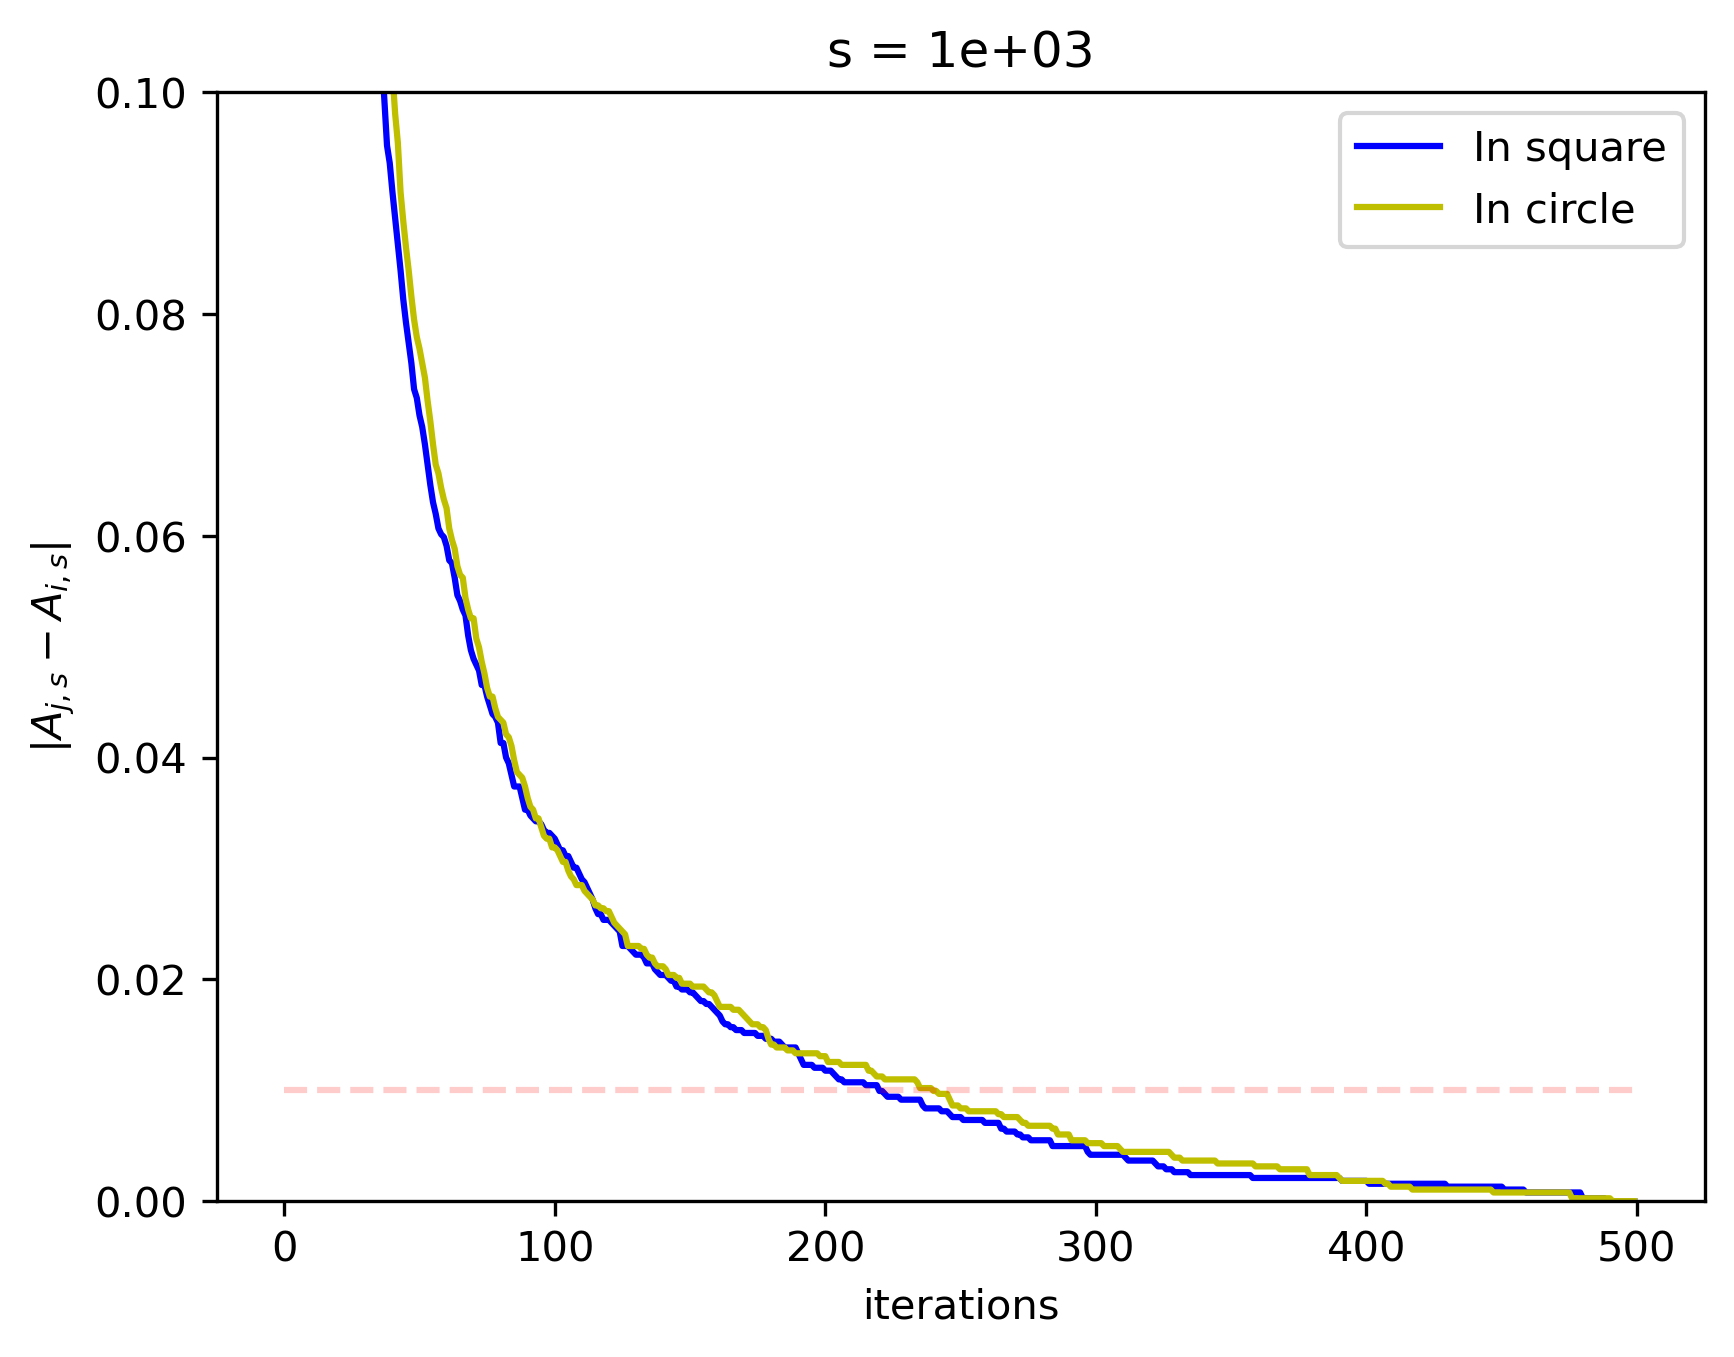

In [186]:
# Compare the convergence rate of the two orthogonal methods with constant s
i = 500  # Max iterations
s = 1000  # s is constant
x = np.arange(i)
l = np.sqrt(4 * math.pi) / 2  # Make the sampling area the same size

# 1 for in square, 2 for in circle
y1, y2 = [], []
for k in range(50):
    A_h1 = OS_h(-l, l, i, s)
    A_h2 = OS_circle(i, s, R=2)
    y1.append(np.abs(A_h1 - A_h1[-1]))
    y2.append(np.abs(A_h2 - A_h2[-1]))
mean1 = np.mean(y1, axis=0)
mean2 = np.mean(y2, axis=0)

print("The first j that achieves the expect accuracy:")
expect_acc = 0.01  # Expected accuracy
print("OS:", np.where(mean1 <= expect_acc)[0][0])
print("OSC:", np.where(mean2 <= expect_acc)[0][0])

plt.figure(dpi=300)
plt.plot(x, mean1, label="In square", c='b')
plt.plot(x, mean2, label="In circle", c='y')
plt.hlines(expect_acc, 0, i, linestyle='dashed', color='red', alpha=0.2)
plt.xlabel("iterations")
plt.ylabel(r"$|A_{j,s}-A_{i,s}|$")
plt.title("s = {:.0e}".format(s))
plt.ylim(0, 0.1)
plt.legend()
plt.show()

In [4]:
# # Try to compute the exact value of A_M
# i = 1000
# s = int(1e7)
# A_h = OS_circle(iter_num=i, s_num=s, R=2)
# print(A_h[-1])

In [109]:
# Computing the escape time j
def escape_time(iter_num, s_num, xlow, xhigh, ylow, yhigh):
    sqr = int(np.floor(np.sqrt(s_num)))
    if sqr % 2 != 0:
        sqr += 1
    s_num = sqr**2
    col_boundings = np.linspace(xlow, xhigh, sqr + 1)
    row_boundings = np.linspace(ylow, yhigh, sqr + 1)
    js_up = np.zeros((int(sqr / 2), sqr))
    for i in range(int(sqr / 2)):
        for j in range(sqr):
            real = (col_boundings[j] + col_boundings[j + 1]) / 2
            imag = (row_boundings[i] + row_boundings[i + 1]) / 2
            c = complex(real, imag)
            js_up[i, j] = wlms(c, iter_num)
    js_low = js_up[::-1]
    js = np.vstack((js_up, js_low))

    return js

In [367]:
iter_num = 100
s_num = int(1e6)
xlow, xhigh = -2, 1
ylow, yhigh = -1.5, 1.5
sqr = int(np.floor(np.sqrt(s_num)))
s_num = sqr**2
js = escape_time(iter_num, s_num, xlow, xhigh, ylow, yhigh)

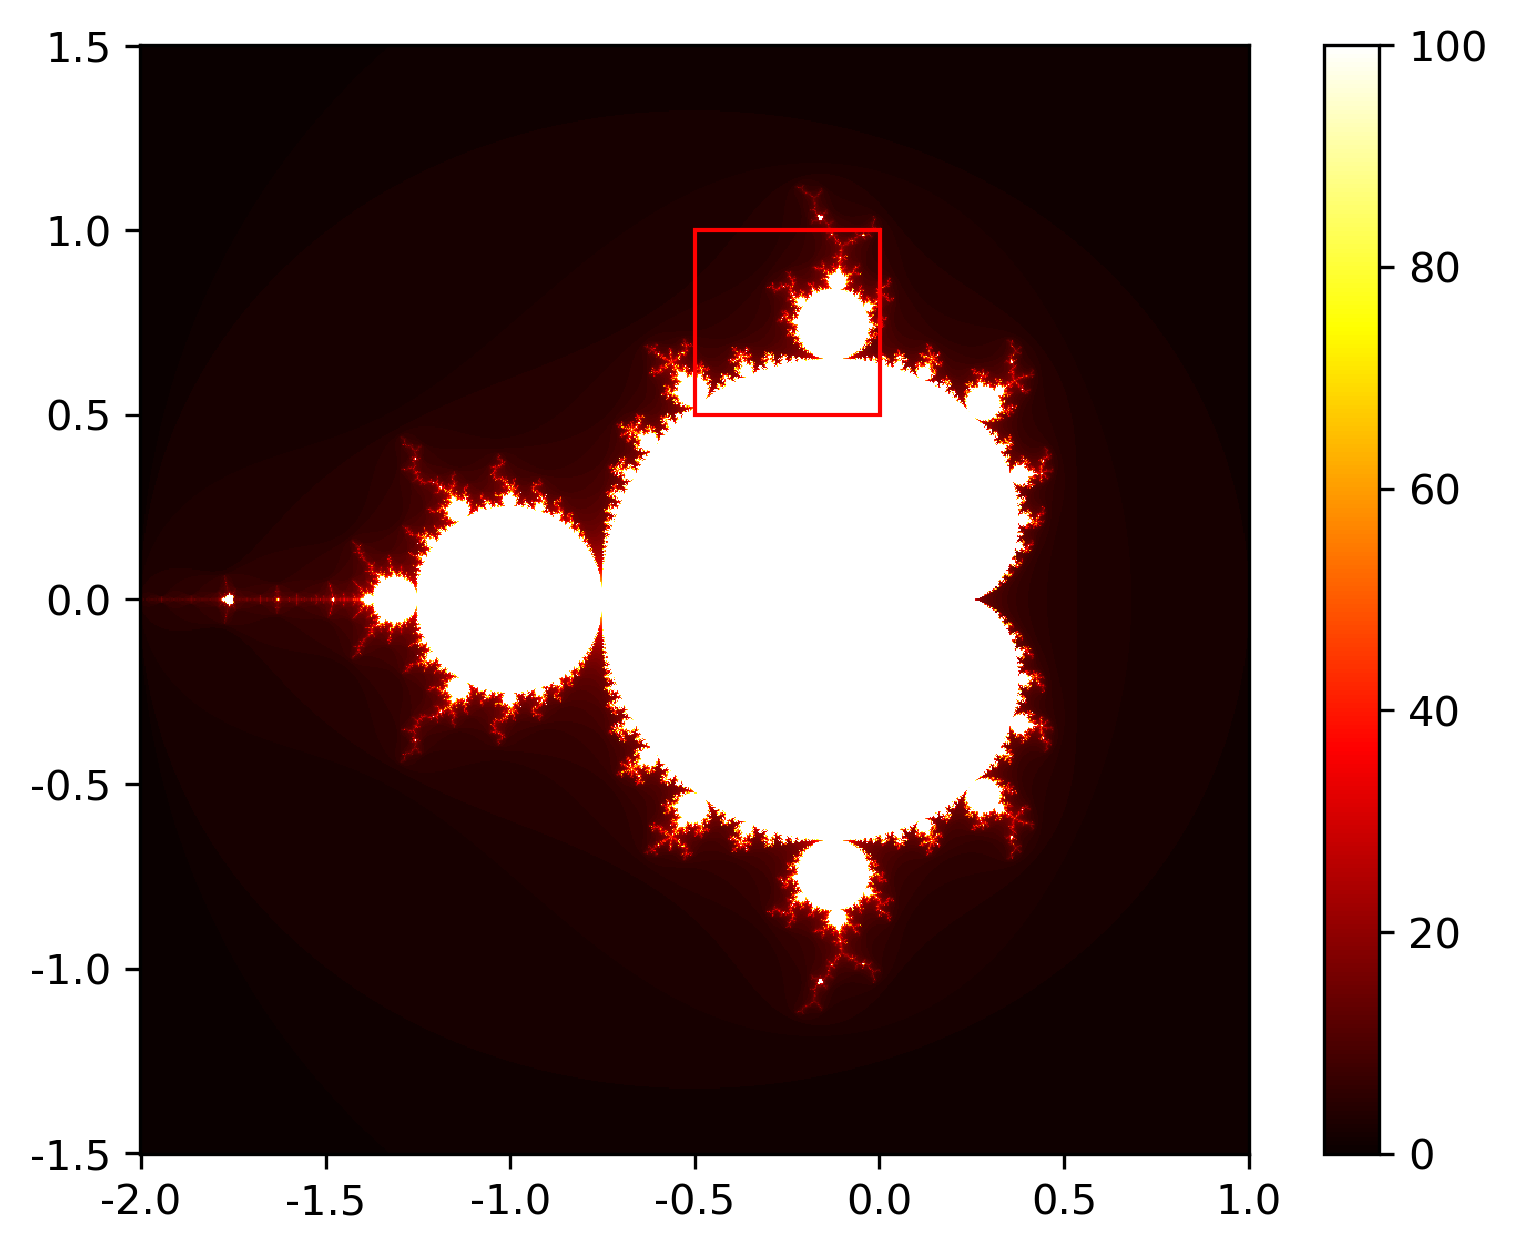

In [368]:
# Global heatmap
fig, ax = plt.subplots(dpi=300)
im1 = ax.imshow(js, cmap='hot', interpolation='nearest')
old_xticks = np.linspace(0, sqr - 1, 7)
old_yticks = np.linspace(sqr - 1, 0, 7)
new_xticks = np.linspace(xlow, xhigh, 7)
new_yticks = np.linspace(ylow, yhigh, 7)
ax.set_xticks(old_xticks, new_xticks)
ax.set_yticks(old_yticks, new_yticks)
rect = plt.Rectangle((sqr / 2, sqr / 6),
                     sqr / 6,
                     sqr / 6,
                     fill=False,
                     edgecolor='red',
                     linewidth=1)
ax.add_patch(rect)
plt.colorbar(im1)
plt.show()

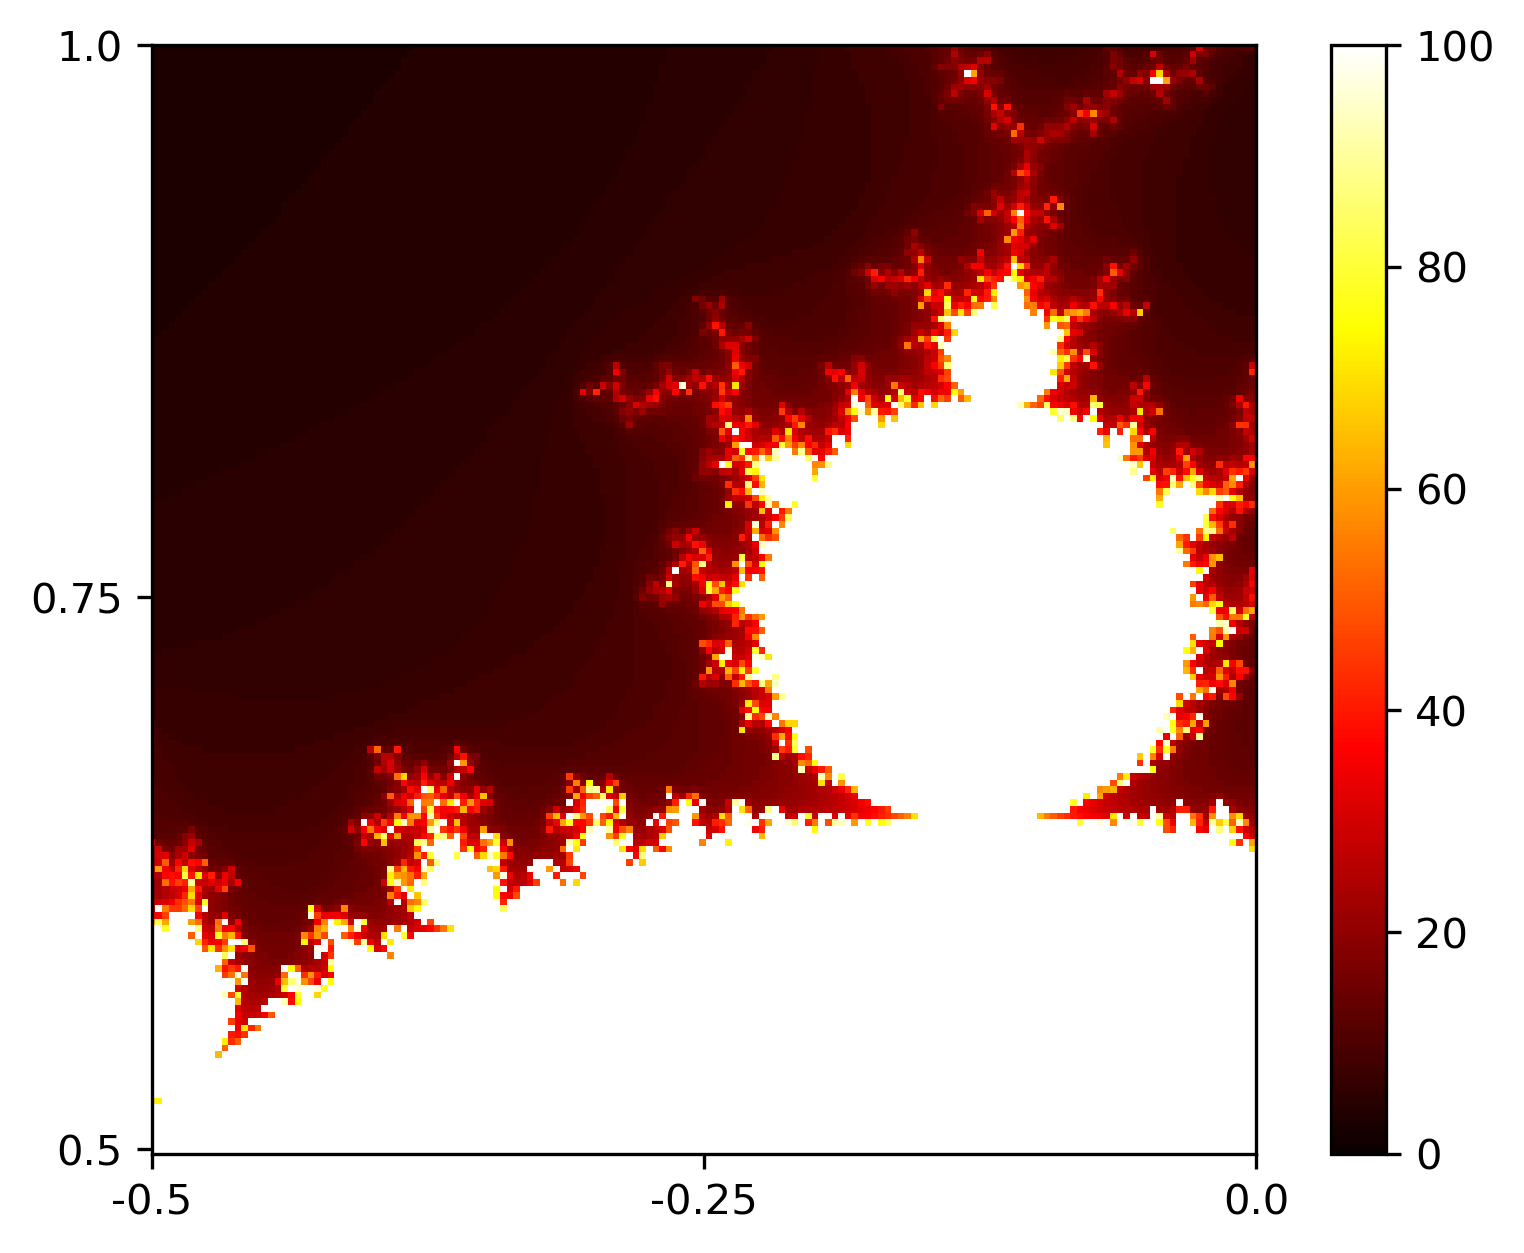

In [369]:
# Local heatmap
plt.figure(dpi=300)
plt.imshow(js, cmap='hot', interpolation='nearest')
plt.xlim(int(sqr / 2), int(sqr / 2 + sqr / 6))
plt.ylim(int(4 / 6 * sqr), int(5 / 6 * sqr))
old_xticks = np.linspace(sqr / 2, sqr / 2 + sqr / 6, 3)
old_yticks = np.linspace(4 / 6 * sqr, 5 / 6 * sqr, 3)
new_xticks = np.linspace(-0.5, 0, 3)
new_yticks = np.linspace(0.5, 1, 3)
plt.xticks(old_xticks, new_xticks)
plt.yticks(old_yticks, new_yticks)
plt.colorbar()
plt.show()

In [501]:
# from scipy.ndimage import convolve


def get_edge(js, iter_num, s_num, xlow, xhigh, ylow, yhigh, threshold=20):
    '''Get the edges of Mandelbrot set.
    Parameters:
        js: Escape time of all the grids
        iter_num: Number of iterations
        s_num: Number of samples
        xlow, xhigh, ylow, yhigh: The boundings of the sampling region
    Returns:
        edge_matrix: A boolean matrix, 1 means on the edge
        edge_rows, edge_cols: Sparse representation of the actual position
    '''
    sqr = int(np.floor(np.sqrt(s_num)))
    s_num = sqr**2
    cond = (js > threshold) & (js < iter_num)
    edge_matrix = np.zeros_like(cond)
    rows, cols = np.where(cond)
    for row, col in zip(rows, cols):
        edge_matrix[row - 1:row + 2, col - 1:col + 2] = 1
    # kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    # convolved = convolve(cond, kernel, mode='constant', cval=0)
    # new_cond = convolved > 0
    # convolved = convolve(new_cond, kernel, mode='constant', cval=0)
    # new_cond = convolved > 0
    rows, cols = np.where(edge_matrix)
    edge_rows = np.linspace(ylow, yhigh, sqr + 1)[rows]
    edge_cols = np.linspace(xlow, xhigh, sqr + 1)[cols]

    return edge_matrix, edge_rows, edge_cols

In [500]:
row = 1
col = 1
boolm = np.array([[0,0,0],[0,1,0],[0,0,0]])
boolm[row-1:row+2, col-1:col+2] = 1
print(boolm)

[[1 1 1]
 [1 1 1]
 [1 1 1]]


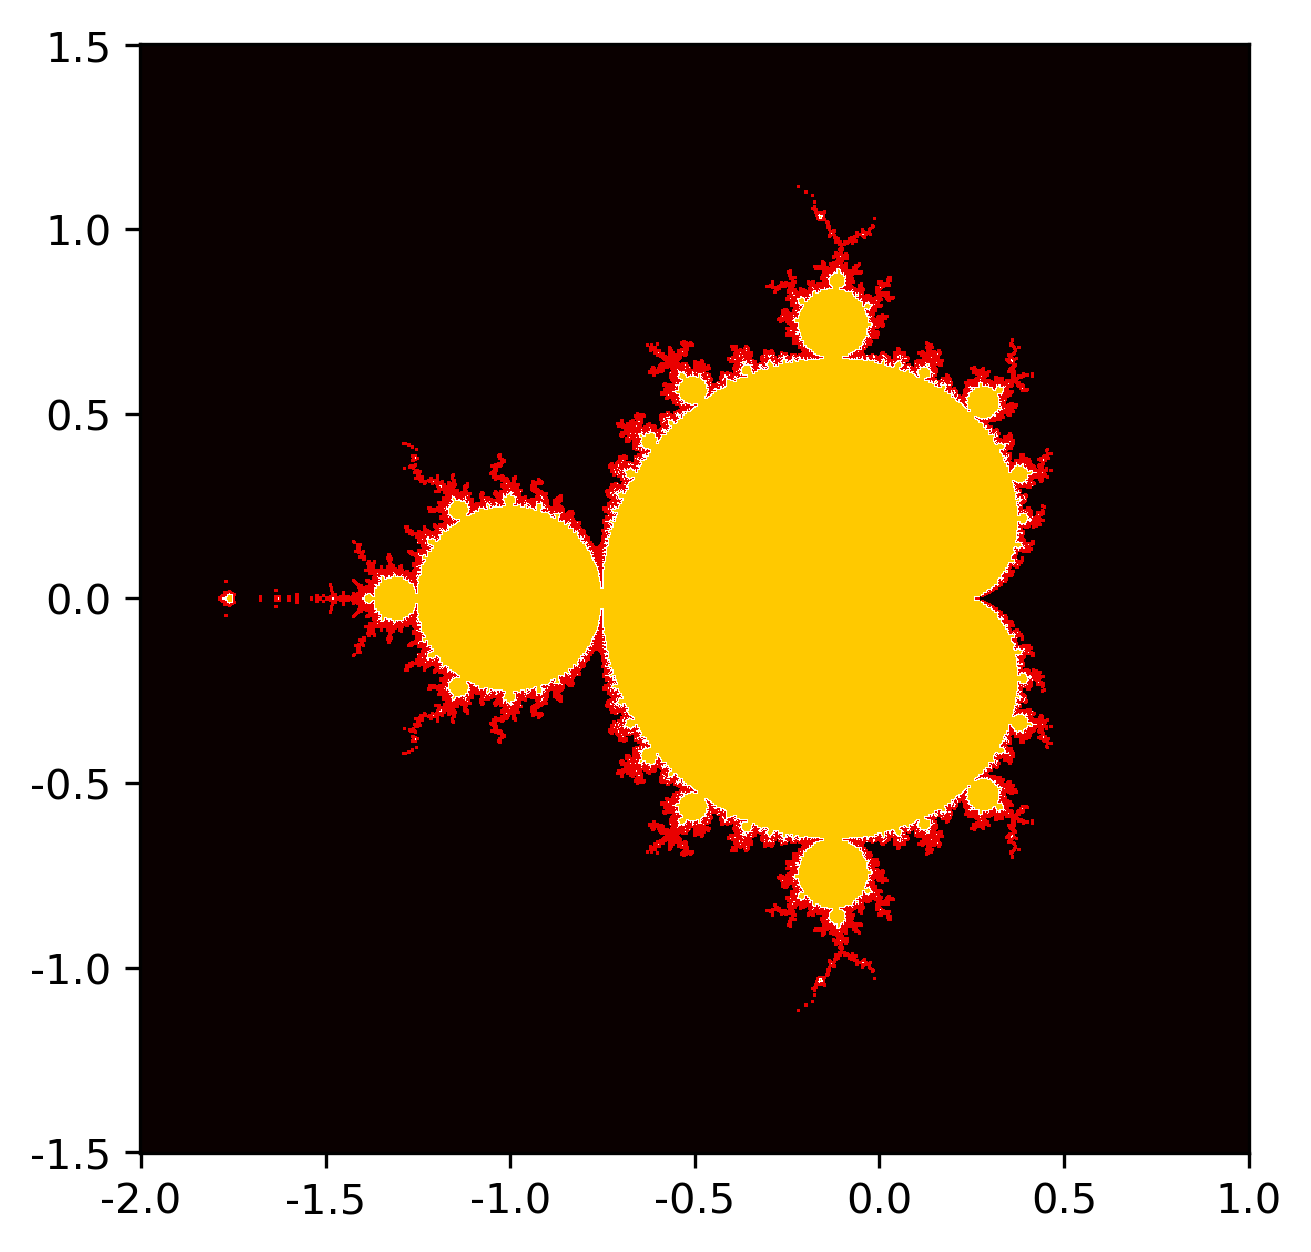

In [506]:
iter_num = 100
s_num = int(1e6)
xlow, xhigh = -2, 1
ylow, yhigh = -1.5, 1.5
sqr = int(np.floor(np.sqrt(s_num)))
js = escape_time(iter_num, s_num, xlow, xhigh, ylow, yhigh)
edge_matrix, _, _ = get_edge(js, iter_num, s_num, xlow, xhigh, ylow, yhigh)
within_region = (js == iter_num)
regions = np.zeros_like(js)
regions += edge_matrix + 2 * within_region

# Show the edge
fig, ax = plt.subplots(dpi=300)
im = ax.imshow(regions, cmap='hot', interpolation='nearest')
old_xticks = np.linspace(0, sqr - 1, 7)
old_yticks = np.linspace(sqr - 1, 0, 7)
new_xticks = np.linspace(xlow, xhigh, 7)
new_yticks = np.linspace(ylow, yhigh, 7)
ax.set_xticks(old_xticks, new_xticks)
ax.set_yticks(old_yticks, new_yticks)

plt.show()

In [487]:
def heuristicSampling(iter_num, s_find_edge, s_num, xmin, xmax, ymin, ymax):
    grid_sqr = int(np.floor(np.sqrt(s_find_edge)))
    s_find_edge = grid_sqr**2
    js = escape_time(iter_num, s_find_edge, xmin, xmax, ymin, ymax)
    edge_matrix, edge_rows, edge_cols = get_edge(js,
                                                 iter_num,
                                                 s_find_edge,
                                                 xmin,
                                                 xmax,
                                                 ymin,
                                                 ymax)
    within_region = (js == iter_num)
    regions = np.zeros_like(js)
    regions += edge_matrix + 2 * within_region
    within_region = (js == iter_num)
    regions = np.zeros_like(js)
    # Let within region = 2, on edge = 1, within becomes edge = 3
    regions += edge_matrix + 2 * within_region
    within_region = regions == 2
    A_total = (xmax - xmin) * (ymax - ymin)
    A_within = A_total * np.sum(within_region) / s_find_edge
    # Compute A_edge
    grid_width = (xmax - xmin) / grid_sqr
    grid_height = (ymax - ymin) / grid_sqr
    grid_area = grid_width * grid_height
    # We have used some samples to find the edge
    s_num -= s_find_edge
    edge_grid_num = len(edge_rows)
    edge_grid_area = edge_grid_num * grid_area
    s_per_grid = int(np.floor(s_num / edge_grid_num))
    # Compute how many samples on the edge are in the M set
    N_edge = 0
    for row, col in zip(edge_rows, edge_cols):
        for s in range(s_per_grid):
            imag = np.random.uniform(row, row + grid_height)
            real = np.random.uniform(col, col + grid_width)
            c = complex(real, imag)
            N_edge += ims(c=c, iterations=iter_num)
    A_edge = N_edge / (s_per_grid * edge_grid_num) * edge_grid_area

    return A_within + A_edge

In [488]:
# constant s, varying i
i_s = range(100, 1100, 100)
s_find_edge = int(1e4)
s_num = int(1e5)
mean_OS, mean_HS = [], []
std_OS, std_HS = [], []
for i in i_s:
    As_OS, As_HS = [], []
    for j in range(20):
        As_OS.append(OS(-2, 2, i, s_num))
        As_HS.append(heuristicSampling(i, s_find_edge, s_num, -2, 2, -2, 2))
    mean_OS.append(np.mean(As_OS))
    mean_HS.append(np.mean(As_HS))
    std_OS.append(np.std(As_OS))
    std_HS.append(np.std(As_HS))

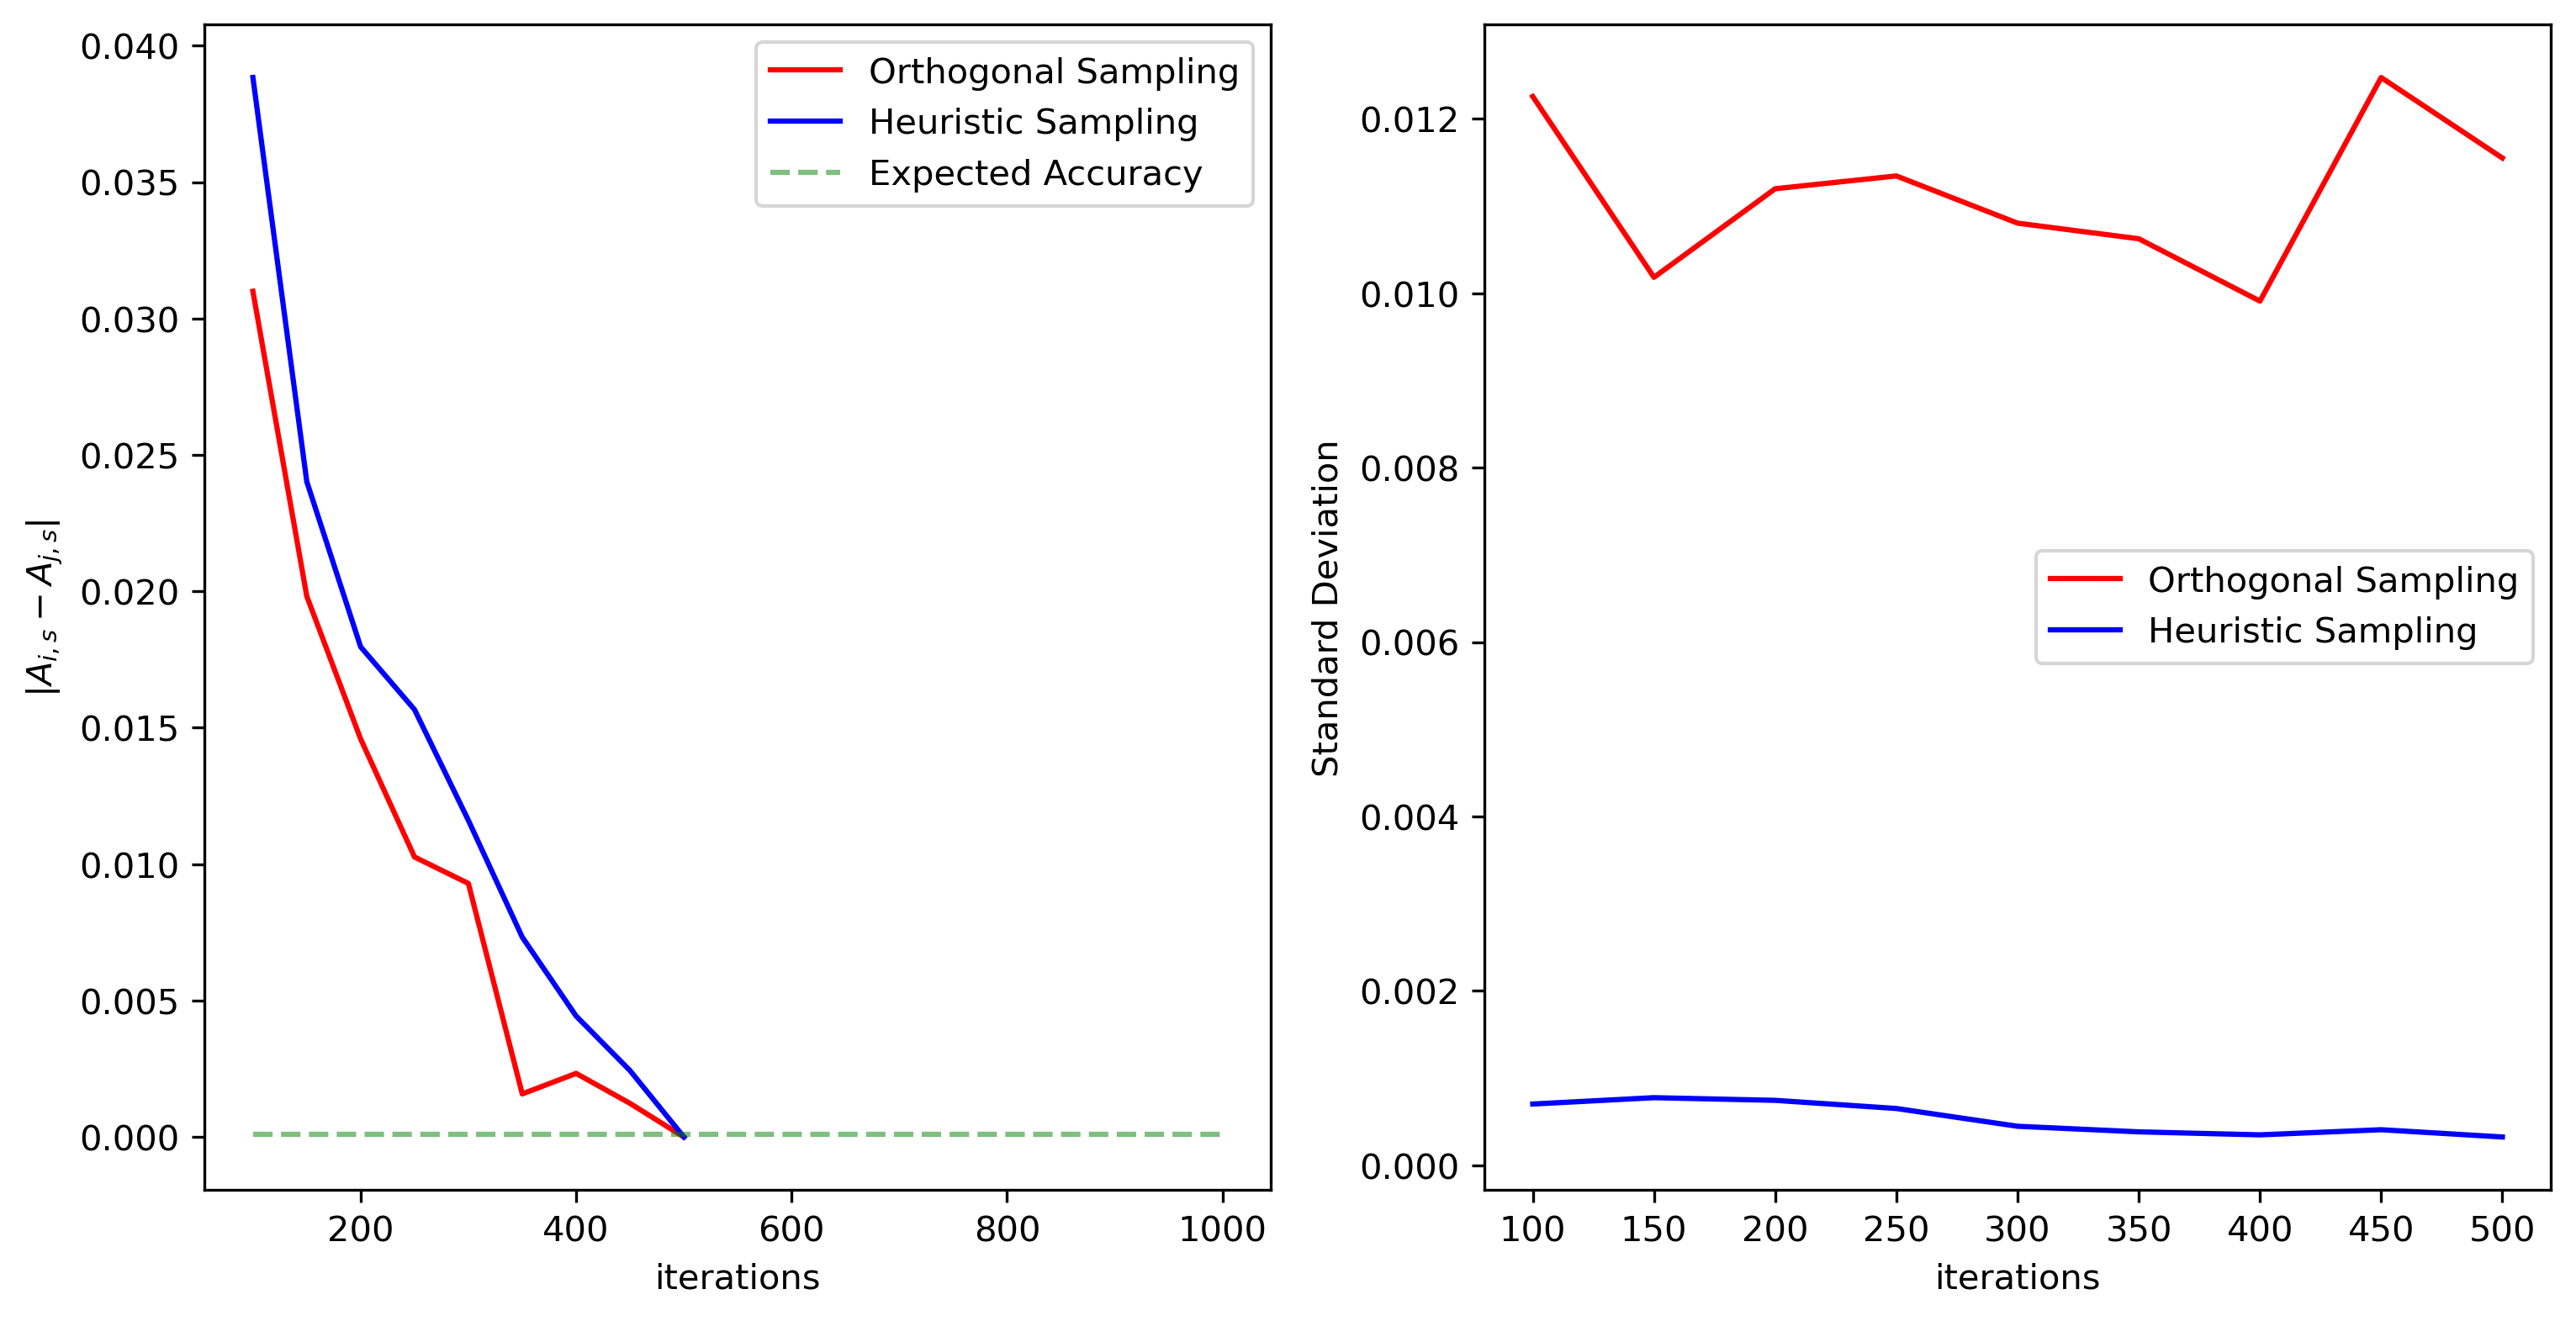

In [485]:
# Plot
mean_OS = np.array(mean_OS)
mean_HS = np.array(mean_HS)
std_OS = np.array(std_OS)
std_HS = np.array(std_HS)
deltaA_OS = np.abs(mean_OS-mean_OS[-1])
deltaA_HS = np.abs(mean_HS-mean_HS[-1])
expected_accuracy = 1e-4

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
axes[0].set_xlabel("iterations")
axes[0].set_ylabel("$|A_{i,s}-A_{j,s}|$")
axes[0].plot(i_s, deltaA_OS, label='Orthogonal Sampling', c='r')
axes[0].plot(i_s, deltaA_HS, label='Heuristic Sampling', c='b')
axes[0].hlines(expected_accuracy, 100, 1000, linestyle='dashed', color="green", alpha=0.5, label='Expected Accuracy')
axes[0].legend()
axes[1].set_xlabel("iterations")
axes[1].set_ylabel("Standard Deviation")
axes[1].plot(i_s, std_OS, label='Orthogonal Sampling', c='r')
axes[1].plot(i_s, std_HS, label='Heuristic Sampling', c='b')
axes[1].legend()
plt.show()

In [478]:
print(mean_OS[-1])
print(mean_HS[-1])

1.6324661810613943
1.6243080124869926


constant i, varying s

In [464]:
# constant i, varying s
i = 50
s_num = range(2000, 3100, 100)
s_find_edge = 1000
mean_OS, mean_HS = [], []
std_OS, std_HS = [], []
for s in s_num:
    As_OS, As_HS = [], []
    for j in range(50):
        As_OS.append(OS(-2, 2, i, s))
        As_HS.append(heuristicSampling(i, s_find_edge, s, -2, 2, -2, 2))
    mean_OS.append(np.mean(As_OS))
    mean_HS.append(np.mean(As_HS))
    std_OS.append(np.std(As_OS))
    std_HS.append(np.std(As_HS))

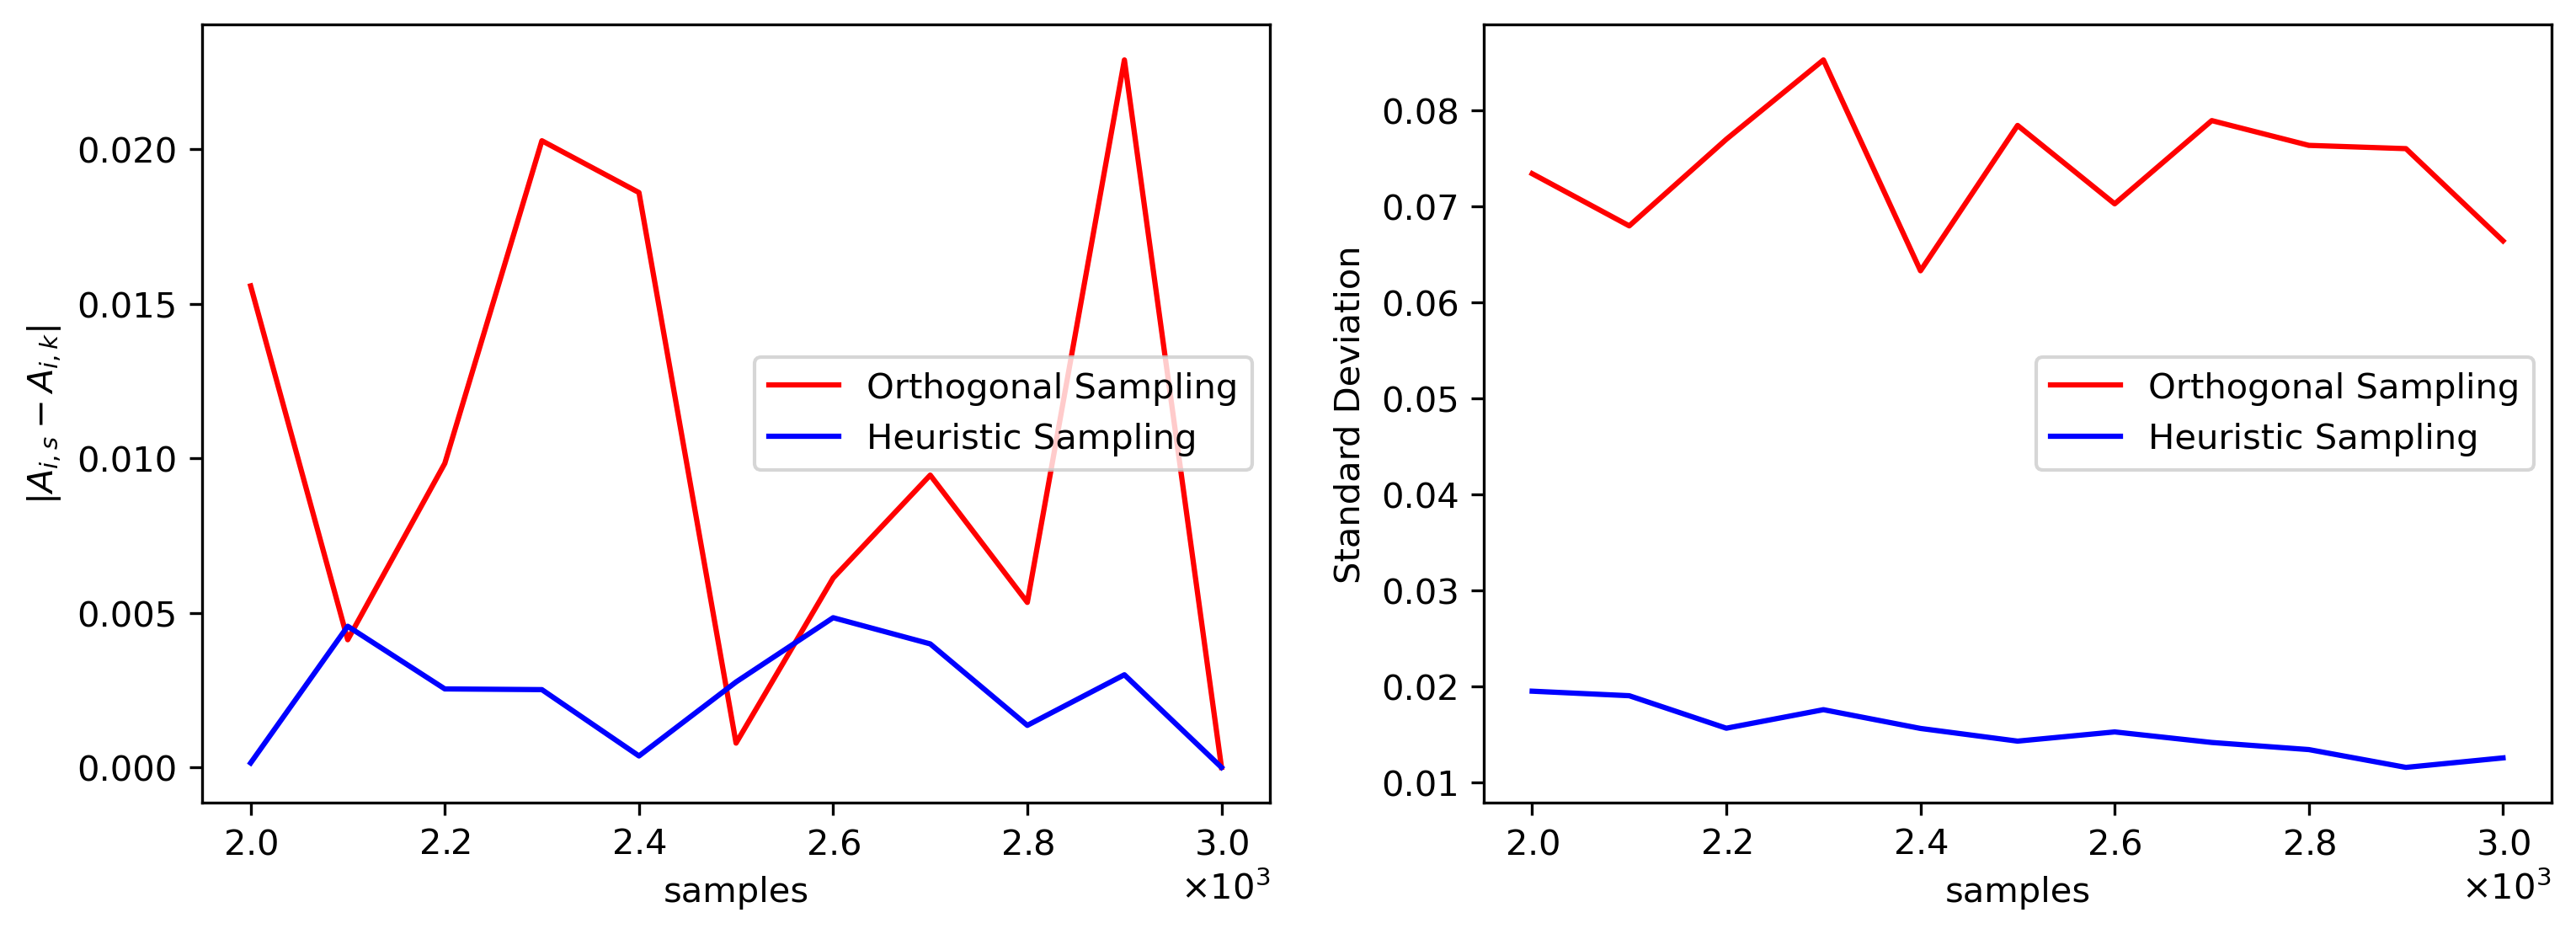

In [465]:
# Plot
mean_OS = np.array(mean_OS)
mean_HS = np.array(mean_HS)
std_OS = np.array(std_OS)
std_HS = np.array(std_HS)
deltaA_OS = np.abs(mean_OS-mean_OS[-1])
deltaA_HS = np.abs(mean_HS-mean_HS[-1])
expected_accuracy = 1e-4

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
axes[0].set_xlabel("samples")
axes[0].set_ylabel("$|A_{i,s}-A_{i,k}|$")
axes[0].plot(s_num, deltaA_OS, label='Orthogonal Sampling', c='r')
axes[0].plot(s_num, deltaA_HS, label='Heuristic Sampling', c='b')
# axes[0].hlines(expected_accuracy, 100, 1000, linestyle='dashed', color="green", alpha=0.5, label='Expected Accuracy')
axes[0].legend()
axes[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].set_xlabel("samples")
axes[1].set_ylabel("Standard Deviation")
axes[1].plot(s_num, std_OS, label='Orthogonal Sampling', c='r')
axes[1].plot(s_num, std_HS, label='Heuristic Sampling', c='b')
axes[1].legend()
axes[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

quasi random sampling

In [419]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def mandelbrot(c, max_iter):
    z = 0
    for n in range(max_iter):
        z = z*z + c
        if abs(z) > 2:
            return n
    return max_iter


def sobolSampling(i, s, xmin, xmax, ymin, ymax):
    # 生成Sobol序列样本
    sampler = qmc.Sobol(d=2, scramble=False)
    samples = sampler.random(sample_size)
    samples[:, 0] = samples[:, 0] * (xhigh - xlow) + xlow
    samples[:, 1] = samples[:, 1] * (yhigh - ylow) + ylow

    # 检查每个点是否属于Mandelbrot集
    inside = [mandelbrot(complex(x, y), max_iter) == max_iter for x, y in samples]

    # 估计Mandelbrot集的面积
    area_estimate = np.sum(inside) / sample_size * (xhigh - xlow) * (yhigh - ylow)
    return area_estimate

    # 可视化
    # plt.scatter(samples[:, 0], samples[:, 1], c=inside, cmap='viridis', marker=',')
    # plt.xlim(xlow, xhigh)
    # plt.ylim(ylow, yhigh)
    # plt.xlabel('Real')
    # plt.ylabel('Imaginary')
    # plt.show()


In [ ]:
max_iter = 1000
sample_size = 10000
xlow, xhigh = -2, 1
ylow, yhigh = -1.5, 1.5

In [474]:
# constant i, varying s
i = 50
s_num = range(10, 1000, 10)
mean_OS, mean_SS = [], []
std_OS, std_SS = [], []
for s in s_num:
    As_OS, As_SS = [], []
    for j in range(20):
        As_OS.append(OS(-2, 2, i, s))
        As_SS.append(sobolSampling(i, s, -2, 2, -2, 2))
    mean_OS.append(np.mean(As_OS))
    mean_SS.append(np.mean(As_HS))
    std_OS.append(np.std(As_OS))
    std_SS.append(np.std(As_HS))

/Users/terry/anaconda3/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [475]:
print(mean_SS)

[1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926, 1.6243080124869926,

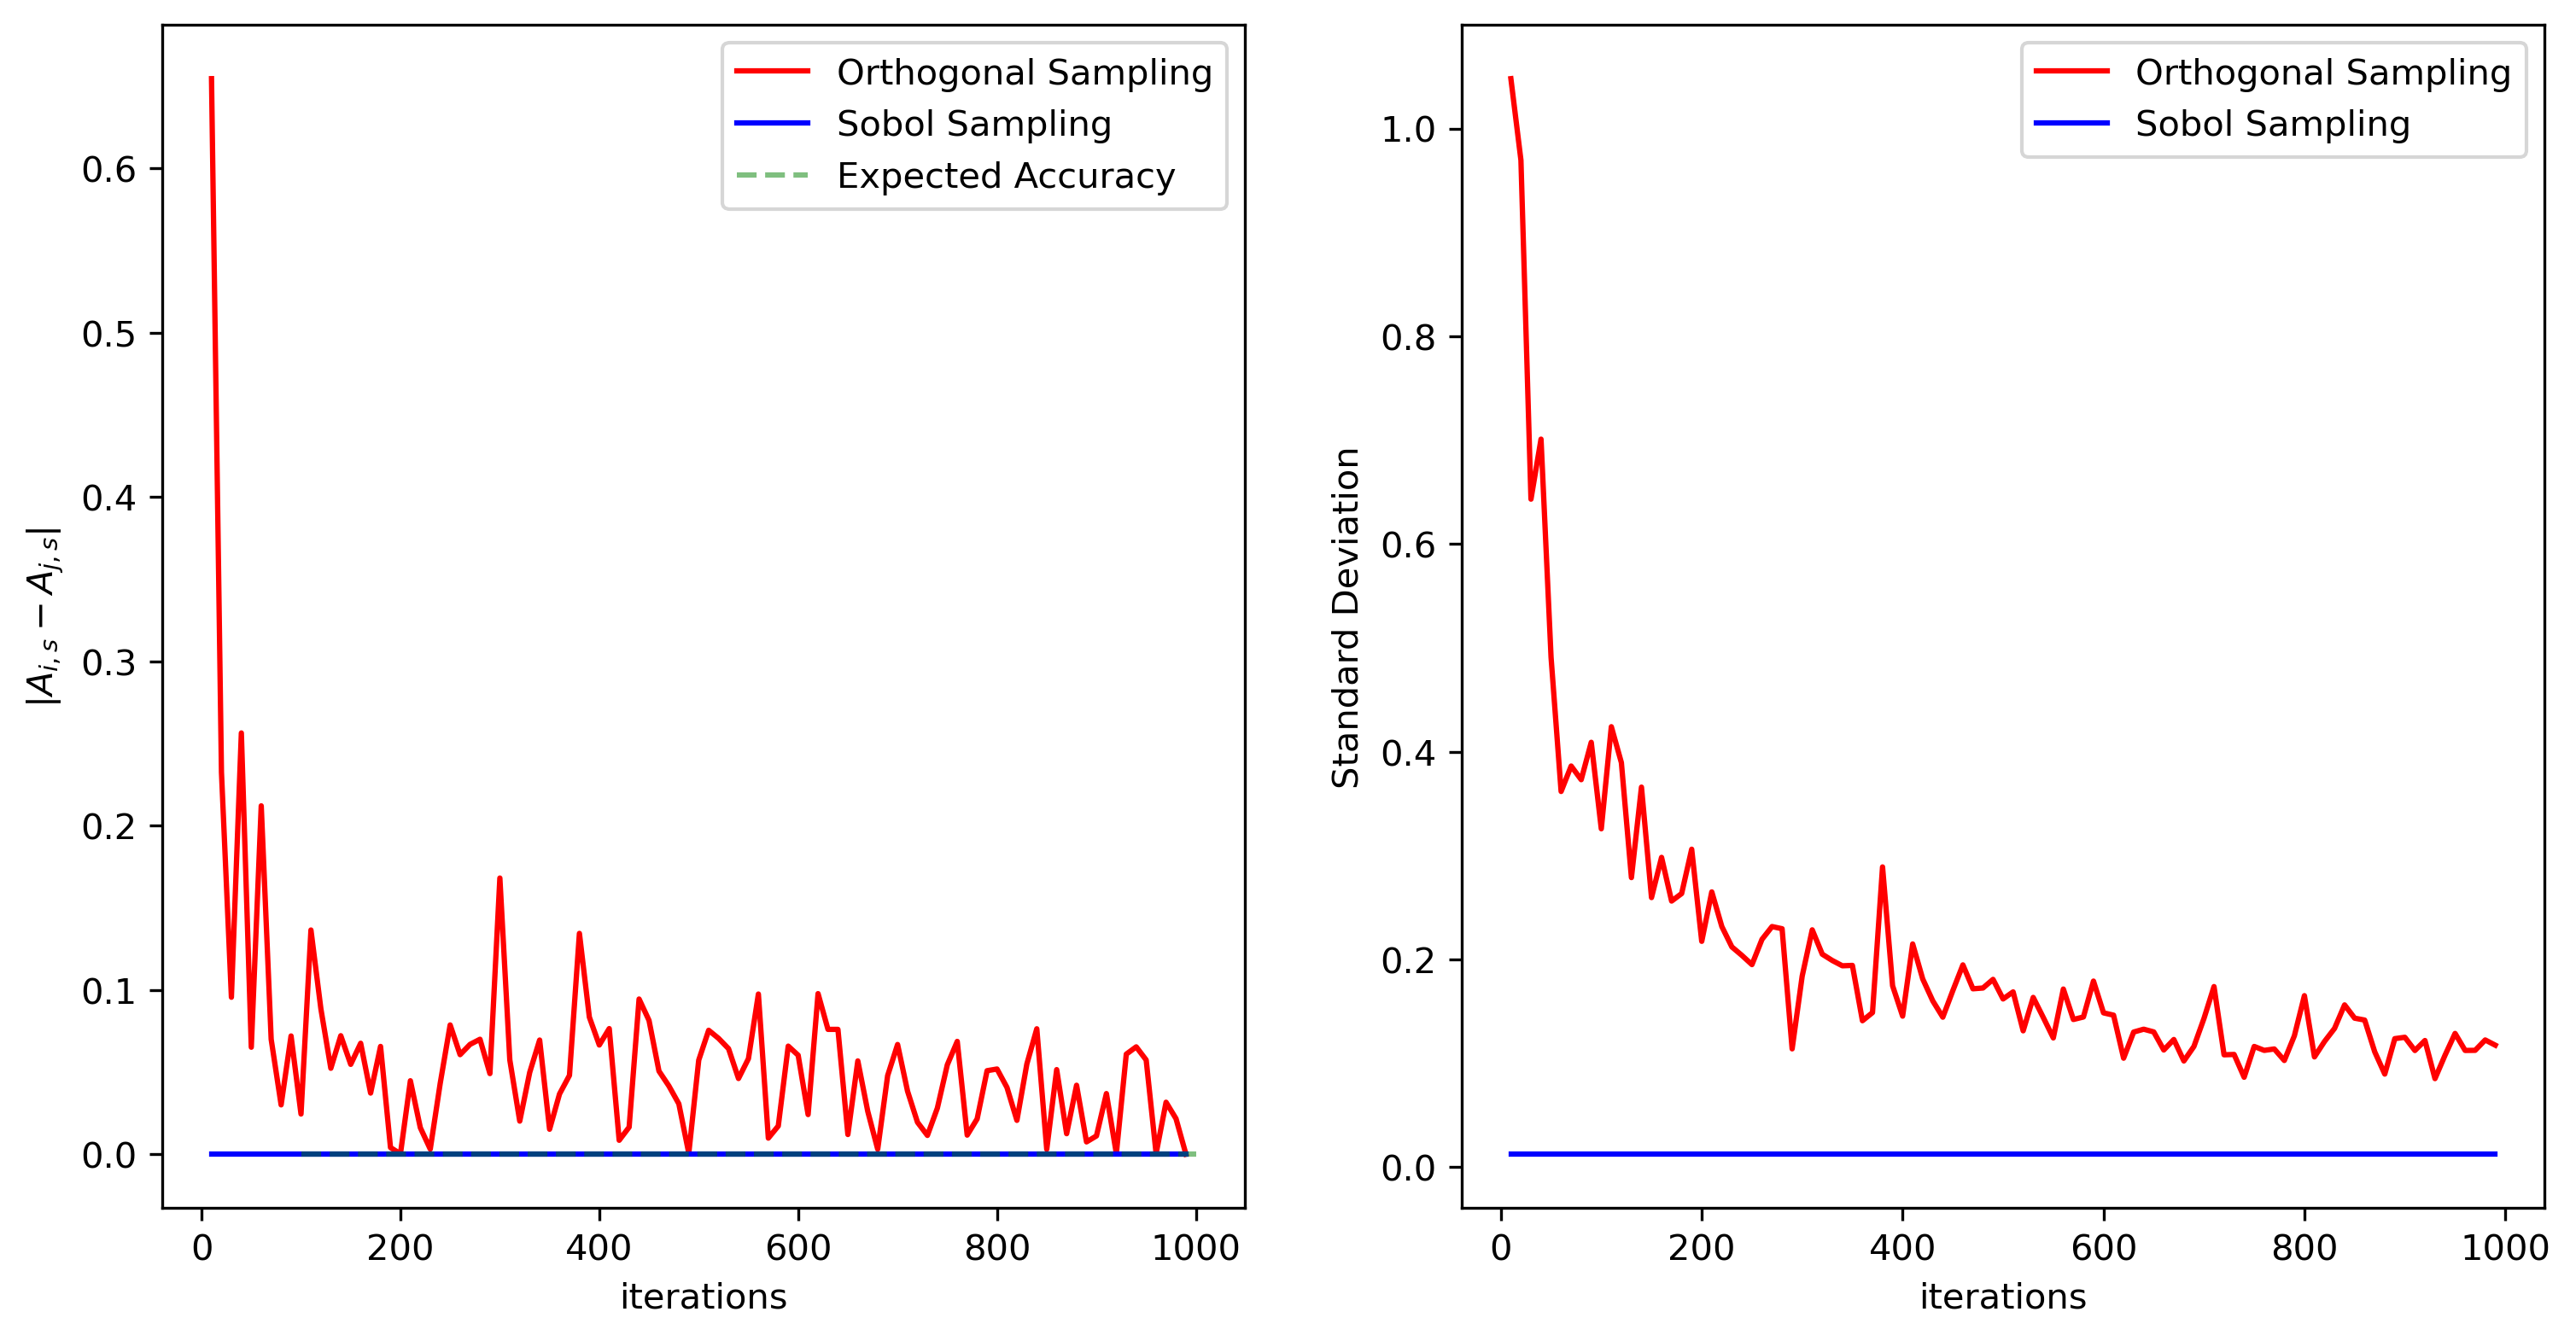

In [476]:
# Plot
mean_OS = np.array(mean_OS)
mean_SS = np.array(mean_SS)
std_OS = np.array(std_OS)
std_SS = np.array(std_SS)
deltaA_OS = np.abs(mean_OS-mean_OS[-1])
deltaA_SS = np.abs(mean_SS-mean_SS[-1])
expected_accuracy = 1e-4

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
axes[0].set_xlabel("iterations")
axes[0].set_ylabel("$|A_{i,s}-A_{j,s}|$")
axes[0].plot(s_num, deltaA_OS, label='Orthogonal Sampling', c='r')
axes[0].plot(s_num, deltaA_SS, label='Sobol Sampling', c='b')
axes[0].hlines(expected_accuracy, 100, 1000, linestyle='dashed', color="green", alpha=0.5, label='Expected Accuracy')
axes[0].legend()
axes[1].set_xlabel("iterations")
axes[1].set_ylabel("Standard Deviation")
axes[1].plot(s_num, std_OS, label='Orthogonal Sampling', c='r')
axes[1].plot(s_num, std_SS, label='Sobol Sampling', c='b')
axes[1].legend()
plt.show()